In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

from pytorched.step_by_step import StepByStep

from torchviz import make_dot
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Quadratic function fit

Let's make up some data:

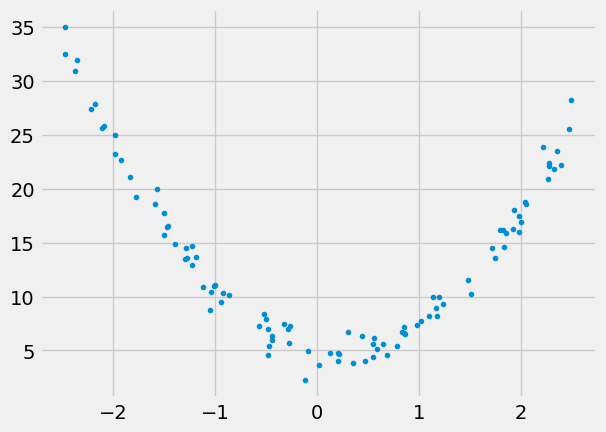

In [ ]:
np.random.seed(43)
a0, a1, a2 = 5., -1.5, +4.
N = 100
x = -2.5 + 5*np.random.rand(N,1)
epsilon = np.random.randn(N,1)
y = a0 + a1*x + a2*x**2 + epsilon
plt.plot(x,y,'.')
plt.show()

# Using sklearn

Somewhat counterintuitively this problem is still [linear regression](https://scikit-learn.org/stable/modules/linear_model.html?highlight=polynomial+regression#polynomial-regression-extending-linear-models-with-basis-functions). We just need to first convert `x` to `new_x` that basically contains extra features: $x^0$, $x^1$, and $x^2$. This is done via `PolynomialFeatures`:

In [ ]:
poly = PolynomialFeatures(degree=2)
new_x = poly.fit_transform(x)  # for degree 2 we get $[1, x, x^2]$
new_x[:10]

array([[ 1.        , -1.92472717,  3.70457467],
       [ 1.        ,  0.5453327 ,  0.29738775],
       [ 1.        , -1.83304518,  3.36005463],
       [ 1.        , -1.2970519 ,  1.68234363],
       [ 1.        , -0.86430472,  0.74702265],
       [ 1.        ,  1.79568745,  3.22449344],
       [ 1.        ,  0.83045107,  0.68964897],
       [ 1.        ,  0.20581106,  0.04235819],
       [ 1.        , -2.35493088,  5.54569944],
       [ 1.        ,  1.16874148,  1.36595665]])

We now progress as with the linear regression (not that using `fit_intercept` True or False just affects the way numbers are stored, all calculations are still there):

In [ ]:
reg = LinearRegression(fit_intercept=False).fit(new_x, y)
r2_coef = reg.score(new_x, y)
print(reg.coef_, reg.intercept_, r2_coef)

[[ 4.98812164 -1.61954639  4.02342307]] 0.0 0.9831534879311261


## Same but using sklearn.pipeline

One can make the process more streamlined using `Pipeline`:

In [ ]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-2 polynomial data
model = model.fit(x, y)
print(model.named_steps['linear'].coef_)
print(f'Real values {a0}, {a1}, {a2}')

[[ 4.98812164 -1.61954639  4.02342307]]
Real values 5.0, -1.5, 4.0


# Using PyTorch

Let's first split data, create `Datasets`, and `DataLoaders`:

## Data Preparation 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
np.random.seed(42)
N = len(x)
idx = list(range(N))
np.random.shuffle(idx)

In [ ]:
split_idx = int(.8*N)
train_idx = idx[:split_idx]
val_idx = idx[split_idx:]
train_x = torch.as_tensor(x[train_idx], device=device).float()
train_y = torch.as_tensor(y[train_idx], device=device).float()
val_x = torch.as_tensor(x[val_idx], device=device).float()
val_y = torch.as_tensor(y[val_idx], device=device).float()

In [ ]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

## Training

In [ ]:
model=nn.Sequential(
        nn.Linear(1,10),
        nn.ReLU(),
        nn.Linear(10,1)
)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

sbs = StepByStep(model, optimizer, loss_fn)

Let's train for 200 epoch and plot losses:


In [ ]:
sbs.set_loaders(train_loader, val_loader)
sbs.train(200)

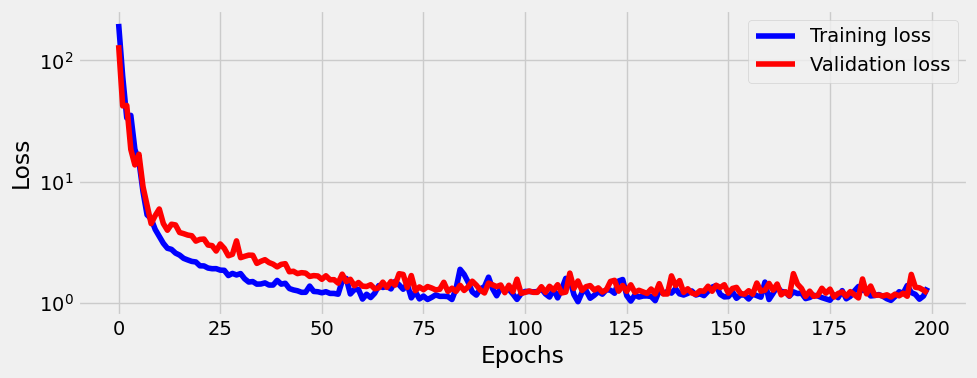

In [ ]:
sbs.plot_losses()

Let's make predictions:

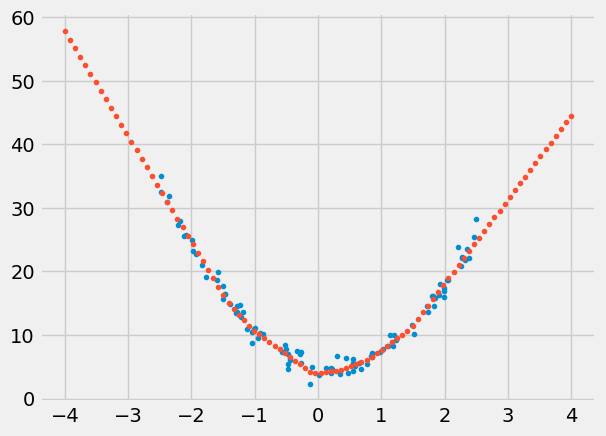

In [ ]:
test =np.linspace(-4.,4.,num=N).reshape(-1,1)
test_predictions = sbs.predict(test)
plt.plot(x,y,'.')
plt.plot(test,test_predictions,'.')
plt.show()

Unfortunatelly, the true values of quadratic function are now lost in the sea of weights of the the two linear layers:

In [ ]:
sbs.model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 1.3475],
                      [-2.2383],
                      [-2.1243],
                      [ 2.0004],
                      [-1.9875],
                      [-2.2052],
                      [ 0.1436],
                      [-1.8479],
                      [ 2.6974],
                      [ 2.1781]])),
             ('0.bias',
              tensor([-1.2300, -3.2117,  0.8249, -1.5303, -0.2013, -2.3025,  1.3949, -0.0182,
                       0.2817, -3.1922])),
             ('2.weight',
              tensor([[0.7446, 2.5052, 1.1556, 1.2103, 1.3438, 1.6768, 0.8039, 1.2448, 1.4132,
                       2.6946]])),
             ('2.bias', tensor([1.5188]))])